## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import numpy as np
print(tf.__version__)
print(pd.__version__)
print(sk.__version__)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, ReLU

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight


2.13.0
2.0.3
1.3.2


**QUESTION:** Load dataset and display some lines of the csv file.

In [230]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Display the first few lines of the dataset
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

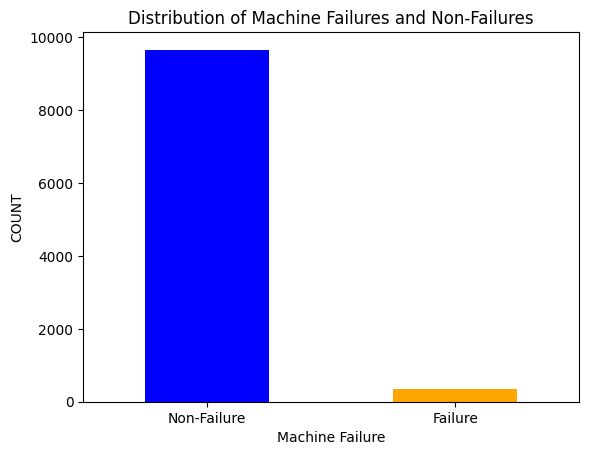

In [231]:
# Count the occurrences of machine failures and non-failures
failure_counts = df['Machine failure'].value_counts()

# Plot the bar graph
failure_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Machine Failures and Non-Failures')
plt.xlabel('Machine Failure')
plt.ylabel('COUNT')
plt.xticks(ticks=[0, 1], labels=['Non-Failure', 'Failure'], rotation=0)
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Très peu de Machine Failure par rapport au non-failure.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Peu de données d'entrainement sur les machine failure. Le modèle pourra peut etre manquer de données d'entrainement.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart.

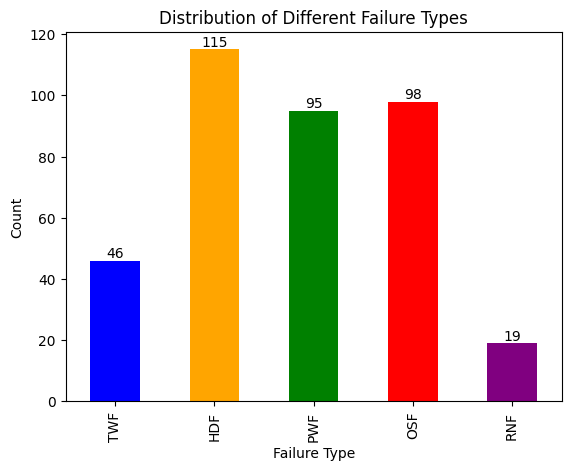

In [232]:
# Count the occurrences of each failure type
failure_types = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

# Plot the bar chart
ax = failure_types.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Distribution of Different Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')

# Display the exact values above each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Les differents type de failure sont réparties inegalement. Le "RNF" est très rare, seulement 19 occurences sur les 10000 machines.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

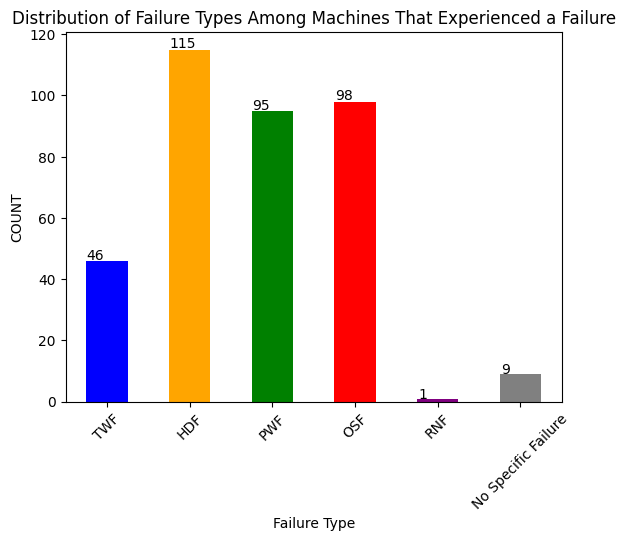

In [233]:
# Filter the dataframe for machines that experienced a failure
failure_df = df[df['Machine failure'] == 1]

# Count the occurrences of each failure type
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failure_df[failure_types].sum()

# Add a "No Specific Failure" category
no_specific_failure_count = (failure_df[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific Failure'] = no_specific_failure_count

# Plot the bar graph
ax = failure_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'gray'])
plt.title('Distribution of Failure Types Among Machines That Experienced a Failure')
plt.xlabel('Failure Type')
plt.ylabel('COUNT')
plt.xticks(rotation=45)

# Display the exact values above each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

La catégorie "No Specific Failure" indique que le dataset peut avoir des informations incomplètes ou manquantes. Cela pourrait impacter la capacité du modèle à prédire précisément les types de pannes, car il pourrait ne pas avoir suffisamment d'informations pour apprendre.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Les entrées seront toutes les colonnes sauf `Machine failure`, `TWF`, `HDF`, `PWF`, `OSF`, `RNF`. Les sorties seront les colonnes `Machine functional`, `TWF`, `HDF`, `PWF`, `OSF`. Cela permet de prédire non seulement si la machine va échouer, mais aussi le type de panne spécifique.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [235]:
# Create a new column for 'Machine functional'
df['Machine functional'] = 1 - df['Machine failure']

X = df.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the number of elements in each set
print(f'Number of elements in X_train: {len(X_train)}')
print(f'Number of elements in Y_train: {len(Y_train)}')
print(f'Number of elements in X_test: {len(X_test)}')
print(f'Number of elements in Y_test: {len(Y_test)}')
print(f'Number of elements in X_val: {len(X_val)}')
print(f'Number of elements in Y_val: {len(Y_val)}')

Number of elements in X_train: 7000
Number of elements in Y_train: 7000
Number of elements in X_test: 1500
Number of elements in Y_test: 1500
Number of elements in X_val: 1500
Number of elements in Y_val: 1500


**QUESTION** Code below the model architecture

In [236]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(5, activation='sigmoid')  # Output layer with 5 neurons for multi-label classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/10
219/219 [==============================] - 4s 15ms/step - loss: 0.2232 - accuracy: 0.9220 - val_loss: 2.2960 - val_accuracy: 0.9687
Epoch 2/10
219/219 [==============================] - 3s 14ms/step - loss: 0.2130 - accuracy: 0.9656 - val_loss: 0.2333 - val_accuracy: 0.9687
Epoch 3/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0712 - accuracy: 0.9673 - val_loss: 0.1844 - val_accuracy: 0.9687
Epoch 4/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0415 - accuracy: 0.9739 - val_loss: 0.1484 - val_accuracy: 0.9687
Epoch 5/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0211 - accuracy: 0.9811 - val_loss: 0.1185 - val_accuracy: 0.9687
Epoch 6/10
219/219 [==============================] - 3s 14ms/step - loss: 0.0136 - accuracy: 0.9870 - val_loss: 0.1420 - val_accuracy: 0.9687
Epoch 7/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0099 - accuracy: 0.9897 - val_loss: 0.1152 - val_accuracy: 0.9687

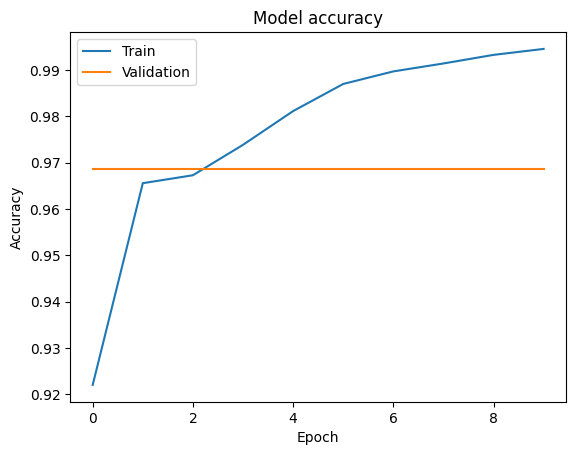

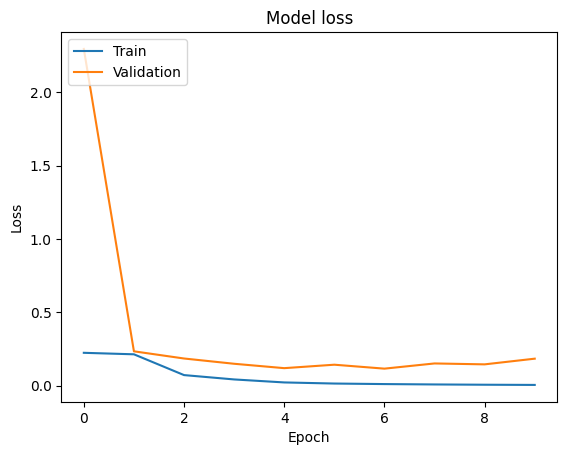

In [237]:
# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=10, validation_data=(X_val_scaled, Y_val))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





47/47 [==============================] - 0s 6ms/step


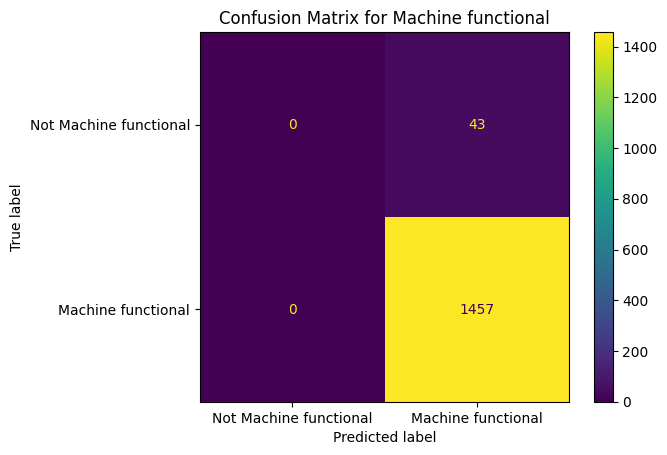

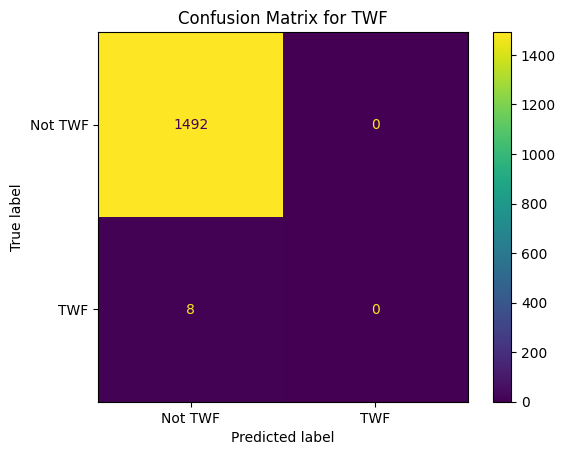

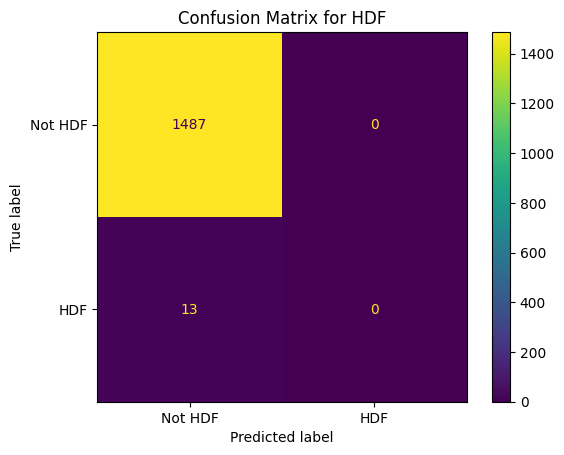

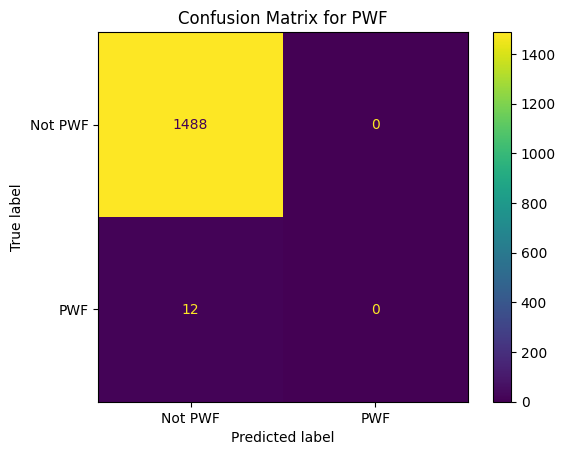

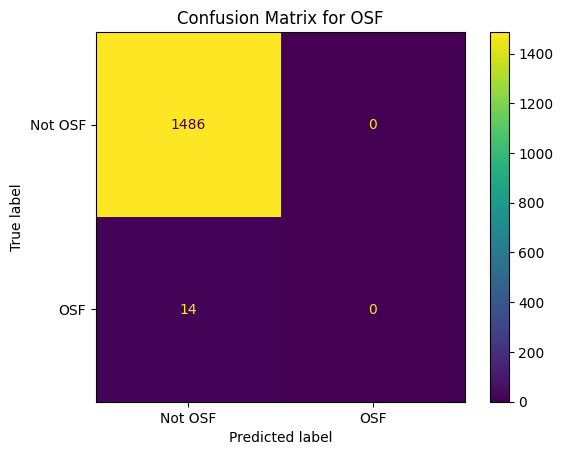

Classification Report:
                    precision    recall  f1-score   support

Machine functional       0.97      1.00      0.99      1457
               TWF       0.00      0.00      0.00         8
               HDF       0.00      0.00      0.00        13
               PWF       0.00      0.00      0.00        12
               OSF       0.00      0.00      0.00        14

         micro avg       0.97      0.97      0.97      1504
         macro avg       0.19      0.20      0.20      1504
      weighted avg       0.94      0.97      0.95      1504
       samples avg       0.97      0.97      0.97      1504



c:\Users\yannb\OneDrive\Documents\ELECTIF_IA\Colab_IA_EMBARQUEE\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [238]:
# Generate predictions
Y_pred = model.predict(X_test_scaled)
Y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Plot confusion matrix for each label
labels = ['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']
for i, label in enumerate(labels):
    cm = confusion_matrix(Y_test.iloc[:, i], Y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
    disp.plot()
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Generate classification report
report = classification_report(Y_test, Y_pred, target_names=labels)
print('Classification Report:')
print(report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

Le modele ne parvient pas à prédire les 'machine failure'. La précision reste tout le de meme eleve puisque le pourcentage de machine failure par rapport au machine fonctionnant est tres faible. Le probleme vient de la mauvaise repartition des data et du trop faible nombre de data avec des failures.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [246]:
# Ensure X and Y are filtered to only have one label per sample
df = pd.read_csv('ai4i2020.csv')
df['Machine functional'] = 1 - df['Machine failure']
Y = df[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]
multiple_labels_mask = (Y.sum(axis=1) > 1)
df_filtered = df[~multiple_labels_mask]

# Create X and Y after filtering
X_filtered = df_filtered.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y_filtered = df_filtered[['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']]

# Convert categorical columns to numeric using one-hot encoding
X_filtered = pd.get_dummies(X_filtered)
Y_filtered = Y_filtered.idxmax(axis=1)

# Split the data into training, testing, and validation sets
X_train_filtered, X_test_filtered, Y_train_filtered, Y_test_filtered = train_test_split(X_filtered, Y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, Y_val_filtered, Y_test_filtered = train_test_split(X_test_filtered, Y_test_filtered, test_size=0.5, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)  # Scaling X_train
X_test_scaled = scaler.transform(X_test_filtered)  # Scaling X_test
X_val_scaled = scaler.transform(X_val_filtered)  # Scaling X_val

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train_filtered)

# Convert Y_train_resampled to one-hot encoding
Y_train_resampled = pd.get_dummies(Y_train_resampled)
Y_test_resampled = pd.get_dummies(Y_test_filtered)
Y_val_resampled = pd.get_dummies(Y_val_filtered)

# Check the number of samples after SMOTE
print(f'Number of elements in X_train_resampled: {len(X_train_resampled)}')
print(f'Number of elements in Y_train_resampled: {len(Y_train_resampled)}')
print(f'Number of elements in X_test_resampled: {len(X_test_scaled)}')
print(f'Number of elements in Y_test_resampled: {len(Y_test_resampled)}')
print(f'Number of elements in X_val_resampled: {len(X_val_scaled)}')
print(f'Number of elements in Y_val_resampled: {len(Y_val_resampled)}')

Number of elements in X_train_resampled: 33855
Number of elements in Y_train_resampled: 33855
Number of elements in X_test_resampled: 1497
Number of elements in Y_test_resampled: 1497
Number of elements in X_val_resampled: 1497
Number of elements in Y_val_resampled: 1497


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [247]:
# Build the neural network model
model = Sequential([
    Dense(128, input_shape=(X_train_resampled.shape[1],)),
    ReLU(),
    Dropout(0.1),
    
    Dense(64),
    ReLU(),
    Dropout(0.1),
    
    Dense(32),
    ReLU(),
    
    Dense(5, activation='softmax')  # Multi-class classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


**QUESTION** Code below the algorithms allowing to train model


Epoch 1/7
529/529 [==============================] - 15s 26ms/step - loss: 0.0584 - accuracy: 0.9524 - val_loss: 3.0316 - val_accuracy: 0.0127
Epoch 2/7
529/529 [==============================] - 12s 24ms/step - loss: 0.0013 - accuracy: 0.9990 - val_loss: 0.1718 - val_accuracy: 0.9726
Epoch 3/7
529/529 [==============================] - 12s 23ms/step - loss: 8.7934e-05 - accuracy: 0.9999 - val_loss: 0.1526 - val_accuracy: 0.9726
Epoch 4/7
529/529 [==============================] - 12s 23ms/step - loss: 2.9489e-05 - accuracy: 1.0000 - val_loss: 0.1747 - val_accuracy: 0.9726
Epoch 5/7
529/529 [==============================] - 12s 23ms/step - loss: 1.1519e-05 - accuracy: 1.0000 - val_loss: 0.1771 - val_accuracy: 0.9726
Epoch 6/7
529/529 [==============================] - 13s 25ms/step - loss: 6.1125e-06 - accuracy: 1.0000 - val_loss: 0.1800 - val_accuracy: 0.9726
Epoch 7/7
529/529 [==============================] - 13s 25ms/step - loss: 5.9442e-06 - accuracy: 1.0000 - val_loss: 0.1804 - 

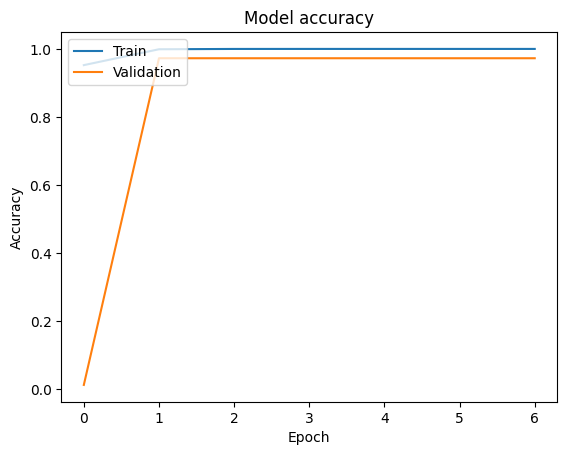

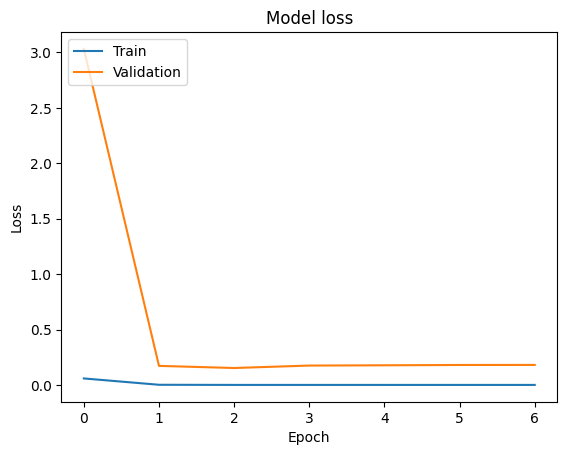

In [248]:
# Train the model
history = model.fit(X_train_resampled, Y_train_resampled, epochs=7, batch_size=64, 
                    validation_data=(X_val_scaled, Y_val_resampled))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

47/47 [==============================] - 0s 8ms/step


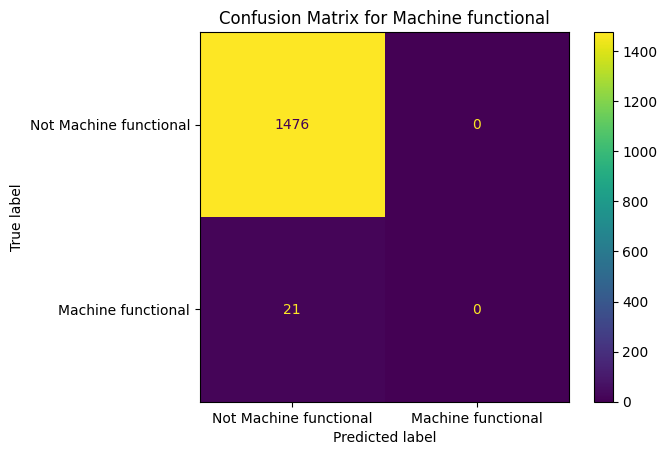

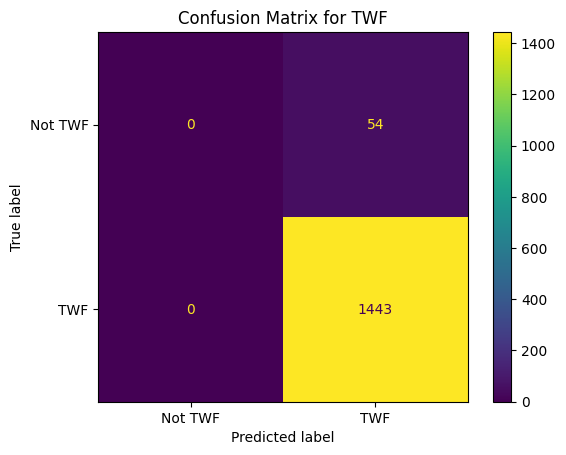

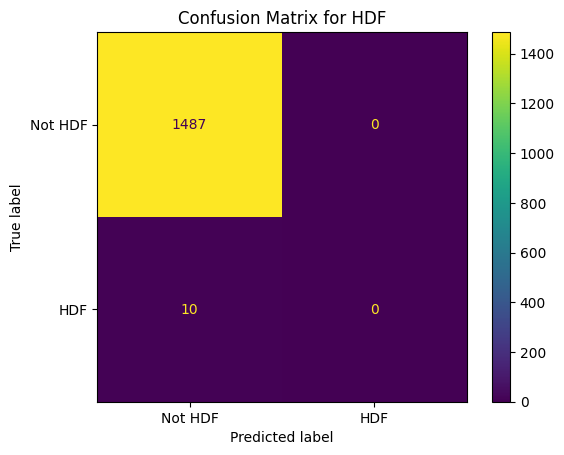

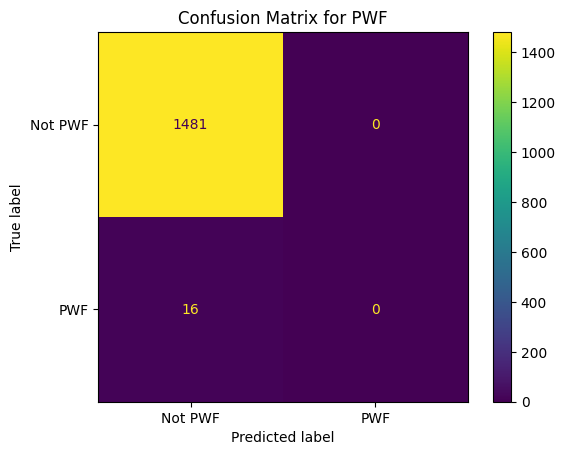

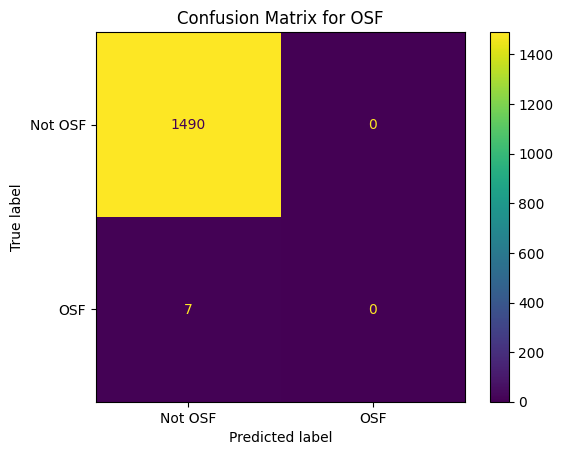

Classification Report:
                    precision    recall  f1-score   support

Machine functional       0.00      0.00      0.00        21
               TWF       0.96      1.00      0.98      1443
               HDF       0.00      0.00      0.00        10
               PWF       0.00      0.00      0.00        16
               OSF       0.00      0.00      0.00         7

         micro avg       0.96      0.96      0.96      1497
         macro avg       0.19      0.20      0.20      1497
      weighted avg       0.93      0.96      0.95      1497
       samples avg       0.96      0.96      0.96      1497



c:\Users\yannb\OneDrive\Documents\ELECTIF_IA\Colab_IA_EMBARQUEE\TP_IA_EMBARQUEE\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [249]:
# Generate predictions
Y_pred = model.predict(X_test_scaled)
Y_pred = (Y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Plot confusion matrix for each label
labels = ['Machine functional', 'TWF', 'HDF', 'PWF', 'OSF']
for i, label in enumerate(labels):
    cm = confusion_matrix(Y_test_resampled.iloc[:, i], Y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
    disp.plot()
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Generate classification report
report = classification_report(Y_test_resampled, Y_pred, target_names=labels)
print('Classification Report:')
print(report)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"